In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from correlation_ansatzs import high_temp_correlation,low_temp_correlation,low_temp_correlation_1,critical_correlation,loglog
from HOTRGZ2 import get_lattice_size,get_dist_torus_2D
import matplotlib as mpl

b)


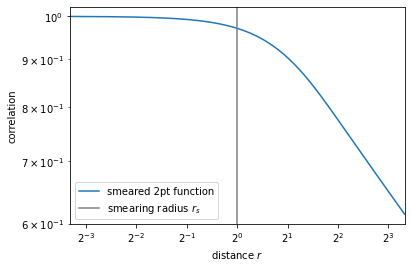

In [87]:
# header dist corr
df=pd.read_csv('./data/Smeared2PTExact.csv',names=['dist','corr'])
plt.plot(df['dist'],df['corr']/df['corr'].max(),label='smeared 2pt function')
plt.axvline(1,ls='-',c='grey',label=r'smearing radius $r_s$')

#log2 scale
plt.xscale(mpl.scale.LogScale('x',base=2));plt.xlim(.1,10)
plt.yscale('log')
plt.xlabel(r'distance $r$')
plt.ylabel(r'correlation')
plt.legend()
print('b)')
plt.show()

In [77]:
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

def firstSharedBlock(x1,y1,x2,y2):
    blockSize=1
    while x1!=x2 or y1!=y2:
        x1,y1,x2,y2=x1//2,y1//2,x2//2,y2//2
        blockSize*=2
    return blockSize


def whichAdjacentWay(x1,y1,x2,y2):
    blockSize=firstSharedBlock(x1,y1,x2,y2)//2
    X1,Y1,X2,Y2=x1//blockSize,y1//blockSize,x2//blockSize,y2//blockSize
    if Y1==Y2:
        return 0 # horizontal
    elif X1==X2:
        return 1 # vertical
    else:
        return 2 # diagonal


def firstSharedLevel(x1,y1,x2,y2):
    level=0
    while x1!=x2 or y1!=y2:
        if level%2==0:
            x1,x2=x1//2,x2//2
        else:
            y1,y2=y1//2,y2//2
        level+=1
    return level

def getBlockSizeFromLevel(l):
    if l%2==0:
        return 2**(l//2),2**(l//2)
    else:
        return 2**(l//2+1),2**(l//2)


def fitWithHuberLoss(x,y,display=False):
    x,y=np.log(x),np.log(y)
    x=x.reshape(-1,1)
    model = HuberRegressor(epsilon=1)
    model.fit(x,y)
    test_x = np.array([np.min(x), np.max(x)]).reshape(-1,1)
    predictions = model.predict(test_x)
    if display:
        plt.scatter(x, y)
        plt.plot(test_x, predictions, 'r')
        plt.show()
    return model.coef_[0],model.intercept_

def distOnTorus(x0,y0,x1,y1,Lx,Ly):
    dx=abs(x0-x1)
    dy=abs(y0-y1)
    dx=min(dx,Lx-dx)
    dy=min(dy,Ly-dy)
    return np.sqrt(dx**2+dy**2)
    

In [78]:


def fitWithOneSidedHuberLoss(x,y,epsilon=1,
                             allow_positive=True,allow_negative=True,
                             x_cutoff=None):
    def loss(xs,ys,k,b):
        dist=ys-k*xs-b
        loss1=1/2 * dist**2
        loss2=epsilon*(np.abs(dist)-epsilon/2)
        if allow_positive:
            loss1[dist>epsilon]=loss2[dist>epsilon]
        if allow_negative:
            loss1[dist<-epsilon]=loss2[dist<-epsilon]
        return np.sum(loss1)
    xfit,yfit=x,y
    if x_cutoff is not None:
        mask=(x<x_cutoff)
        xfit,yfit=x[mask],y[mask]
    res=minimize(lambda x: loss(xfit,yfit,x[0],x[1]),[1,0],method='Nelder-Mead',tol=1e-6)
    k,b=res.x
    return k,b
    


fitted params:  -0.23536307644217608 -0.5462912828159048
scaling dimension GILT:  0.11768153822108804
l:  0  size: 1 x 1
l:  1  size: 2 x 1
l:  2  size: 2 x 2
l:  3  size: 4 x 2
l:  4  size: 4 x 4
l:  5  size: 8 x 4
l:  6  size: 8 x 8
l:  7  size: 16 x 8
l:  8  size: 16 x 16
l:  9  size: 32 x 16
l:  10  size: 32 x 32
l:  11  size: 64 x 32
l:  12  size: 64 x 64
l:  13  size: 128 x 64
l:  14  size: 128 x 128
l:  15  size: 256 x 128
l:  16  size: 256 x 256
l:  17  size: 512 x 256
l:  18  size: 512 x 512
l:  19  size: 1024 x 512


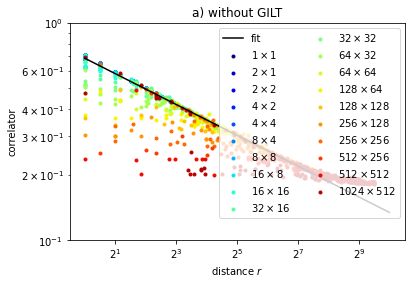

In [79]:
data=pd.read_pickle('data/hotrg_X24_smearing_corner_10.pkl')
title='a) without GILT'
epsilon=.1
x_cutoff=256
# 0.11768153822108804

# data=pd.read_pickle('data/hotrg_gilt_X24_smearing_corner_10.pkl')
# title='b) with GILT'
# epsilon=.1
# x_cutoff=256
# # 0.1309024130988941


data['dist']=data.apply(lambda row: distOnTorus(row['x0'],row['y0'],row['x1'],row['y1'],1024,1024),axis=1)
data['size']=data.apply(lambda row: firstSharedBlock(row['x0'],row['y0'],row['x1'],row['y1'])//2,axis=1)
data['l']=data.apply(lambda row: firstSharedLevel(row['x0'],row['y0'],row['x1'],row['y1'])-1,axis=1)
data['angle']=data.apply(lambda row: np.arctan2(np.abs(row['y1']-row['y0']),np.abs(row['x1']-row['x0'])),axis=1)
data['adj']=data.apply(lambda row: whichAdjacentWay(row['x0'],row['y0'],row['x1'],row['y1']),axis=1)
data=data.sort_values(by=['size','dist'])

k,b=fitWithOneSidedHuberLoss(np.log2(data['dist']),np.log2(data['correlation']),
                             epsilon=epsilon,
                             allow_positive=False,allow_negative=True,
                             x_cutoff=np.log2(x_cutoff))
print('fitted params: ',k,b)
print('scaling dimension GILT: ',-k/2)
test_x=np.geomspace(1,1024,100)
test_y=np.exp2(k*np.log2(test_x)+b)

plt.figure(figsize=(6,4))

plt.plot(test_x,test_y,'black',label='fit')
# for size in sorted(set(data['size'])):
#     color=next(plt.gca()._get_lines.prop_cycler)['color']
#     data_sel=data[data['size']==size]
#     plt.scatter(data_sel['dist'],data_sel['correlation'],color=color,label=r'$l=2^{'+str(int(np.log2(size)))+r'}$')

data_l=[]

for l in sorted(set(data['l'])):
    lx,ly=getBlockSizeFromLevel(l)
    print('l: ',l,' size:',lx,'x',ly)

    color=plt.cm.jet(l/20)
    data_sel=data[data['l']==l].copy()

    marker='.'
    plt.scatter(data_sel['dist'],data_sel['correlation'],color=color,marker=marker,label=r'$'+str(lx)+r'\times'+str(ly)+r'$')

plt.legend(loc='upper right',ncol=2)
plt.xlabel('distance $r$')
plt.ylabel('correlator')
plt.ylim([.1,1])
plt.xscale(mpl.scale.LogScale('x',base=2))
plt.yscale('log')
plt.title(title)

plt.show()


In [80]:




def distToBlockCorner(x,y,lx,ly,normalize=False):
    x,y=x%lx,y%ly
    if normalize:
        x,y=x/lx,y/ly
    dist1=np.sqrt(x**2+y**2)
    dist2=np.sqrt((lx-x)**2+y**2)
    dist3=np.sqrt(x**2+(ly-y)**2)
    dist4=np.sqrt((lx-x)**2+(ly-y)**2)
    return min(dist1,dist2,dist3,dist4)

def cornerRank(x1,y1,x2,y2):
    l=firstSharedLevel(x1,y1,x2,y2)
    lx,ly=getBlockSizeFromLevel(l)
    dist1=distToBlockCorner(x1,y1,lx,ly)
    dist2=distToBlockCorner(x2,y2,lx,ly)
    return max(dist1,dist2)

def fit_line_flat(xs,ys,initial_guess,plot=True, truncate_x=None,bounds=None):
    def loss(xs,ys,k1,b1,b2):
        dist1=np.abs(ys-k1*xs-b1)**2
        dist2=np.abs(ys-b2)**2
        which=np.argmin([dist1,dist2],axis=0)
        cutoff=(b2-b1)/k1
        which[xs>cutoff]=0
        return np.sum(dist1[which==0])+np.sum(dist2[which==1])
    # optimize loss function
    xfit,yfit=xs,ys
    if truncate_x is not None:
        mask=(xs<truncate_x)
        xfit,yfit=xs[mask],ys[mask]
    res=minimize(lambda x: loss(xfit,yfit,x[0],x[1],x[2]),x0=initial_guess,method='Nelder-Mead',tol=1e-6,bounds=bounds)
    k1,b1,b2=res.x
    which=np.argmin([np.abs(ys-k1*xs-b1),np.abs(ys-b2)],axis=0)
    if plot:
        plt.plot(xs[which==0],ys[which==0],'.',color='red')
        plt.plot(xs[which==1],ys[which==1],'.',color='blue')
        plt.plot(xs,k1*xs+b1,color='red')
        plt.plot(xs,b2,color='blue')
        plt.show()
    #k1 x + b1 = b2
    # if too few points are on the second line, remove the second line
    if np.sum(which==1)<6:
        b2=np.nan
    cutoff=(b2-b1)/k1
    return (k1,b1,b2),cutoff,which

l:  10  lx:  32  ly:  32
fitted params:  (-0.23270614389486696, -0.5688567183013304, -0.987244760321836)
scaling dimension:  0.11635307194743348
lower bound:  0.5044402288921251
cutoff:  3.477195898304506
l:  11  lx:  64  ly:  32
fitted params:  (-0.22651906235119995, -0.601428379021168, -1.185381750295859)
scaling dimension:  0.11325953117559998
lower bound:  0.43970817176438476
cutoff:  5.970880182909159
l:  12  lx:  64  ly:  64
fitted params:  (-0.2252909293189742, -0.6061353110416058, -1.2943785708180062)
scaling dimension:  0.1126454646594871
lower bound:  0.40771174691018575
cutoff:  8.3103479117595
l:  13  lx:  128  ly:  64
fitted params:  (-0.1995799597725801, -0.7621750613194327, -1.4521487406139033)
scaling dimension:  0.09978997988629006
lower bound:  0.36547667982719384
cutoff:  10.982457891927458
l:  14  lx:  128  ly:  128
fitted params:  (-0.20678030114128282, -0.7147974102319312, -1.548375604267298)
scaling dimension:  0.10339015057064141
lower bound:  0.3418948024043196

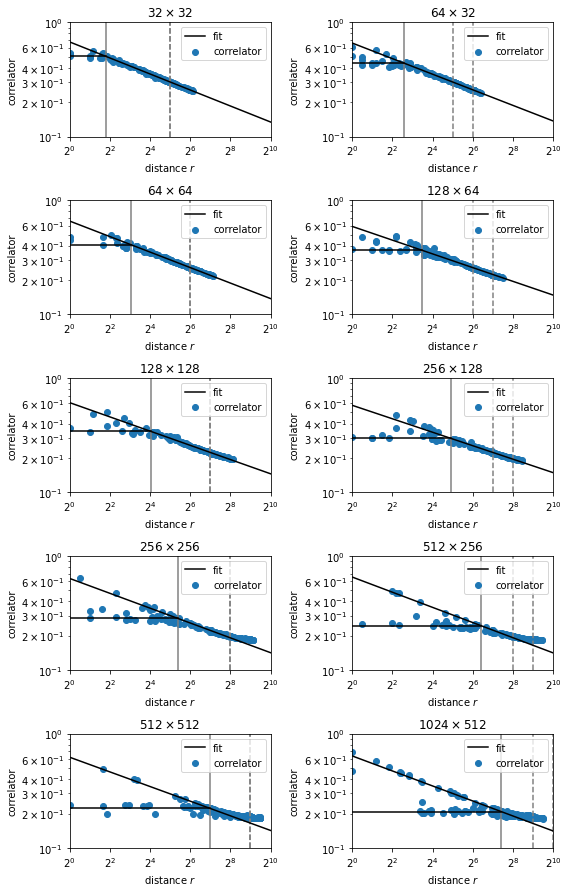

In [246]:
in_one_plot=True
ls=sorted([19,18,17,16,15,14,13,12,11,10])
#ls=list(range(0,20))

data=pd.read_pickle('data/hotrg_X24_smearing_corner_10.pkl')
# data=pd.read_pickle('data/hotrg_gilt_X24_smearing_corner_10.pkl')
data['dist']=data.apply(lambda row: distOnTorus(row['x0'],row['y0'],row['x1'],row['y1'],1024,1024),axis=1)
data['size']=data.apply(lambda row: firstSharedBlock(row['x0'],row['y0'],row['x1'],row['y1'])//2,axis=1)
data['l']=data.apply(lambda row: firstSharedLevel(row['x0'],row['y0'],row['x1'],row['y1'])-1,axis=1)
data['angle']=data.apply(lambda row: np.arctan2(np.abs(row['y1']-row['y0']),np.abs(row['x1']-row['x0'])),axis=1)
data['adj']=data.apply(lambda row: whichAdjacentWay(row['x0'],row['y0'],row['x1'],row['y1']),axis=1)
data['cornerRank']=data.apply(lambda row: cornerRank(row['x0'],row['y0'],row['x1'],row['y1']),axis=1)

data=data.sort_values(by=['dist'],ascending=False)

# for size in [512,256,128,64,32]:
#     data_sel=data[data['size']==size].copy()
if in_one_plot:
    plt.figure(figsize=(8,2.5*((len(ls)+1)//2)))

data_l=[]
for isubplot,l in enumerate(ls):
    if in_one_plot:
        plt.subplot((len(ls)+1)//2,2,isubplot+1)
    lx,ly=getBlockSizeFromLevel(l)
    print('l: ',l,' lx: ',lx,' ly: ',ly)

    data_sel=data[data['l']==l].copy()

    bounds=[[-.35,-.15],[-5,0],[-5,0]]
    initial_guess=[-.25,-.5,-1]
    if l>15:
        initial_guess=[-.25,-.5,-2]
    args,cutoff,which=fit_line_flat(np.log2(data_sel['dist']),np.log2(data_sel['correlation']),plot=False,truncate_x=np.log2(2**8),bounds=bounds,initial_guess=initial_guess)
    cutoff=2**min(cutoff,10)
    scaling_dimension=-args[0]/2
    lower_bound=np.exp2(args[2])
    b_coeff=2**args[1]
    print('fitted params: ',args)
    print('scaling dimension: ',scaling_dimension)
    print('lower bound: ',lower_bound)
    print('cutoff: ',cutoff)
    data_l.append({'l':l,'lx':lx,'ly':ly,'scaling_dimension':scaling_dimension,'lower_bound':lower_bound,'b_coeff':b_coeff,'cutoff':cutoff})

    # draw the fitting
    plt.axvline(cutoff,linestyle='-',color='grey')
    plt.axvline(lx,linestyle='--',color='grey')
    plt.axvline(ly,linestyle='--',color='grey')


    text_x=np.geomspace(1,1024,100)
    text_y=np.exp2(args[0]*np.log2(text_x)+args[1])
    plt.plot(text_x,text_y,'black',label='fit')
    text_x=np.geomspace(1,cutoff,100)
    text_y=np.exp2(args[2])*np.ones_like(text_x)
    plt.plot(text_x,text_y,'black')

    plt.scatter(data_sel['dist'],data_sel['correlation'],label='correlator')

    # draw by adj
    # data_sel_sel=data_sel[data_sel['adj']==0]
    # plt.scatter(data_sel_sel['dist'],data_sel_sel['correlation'],marker='_',color='red',label='horizontally adjacent')
    # data_sel_sel=data_sel[data_sel['adj']==1]
    # plt.scatter(data_sel_sel['dist'],data_sel_sel['correlation'],color='blue',marker='|',label='vertically adjacent')
    # data_sel_sel=data_sel[data_sel['adj']==2]
    # plt.scatter(data_sel_sel['dist'],data_sel_sel['correlation'],color='green',marker='x',label='diagonally adjacent')

    # scatter, color by corner rank
    #plt.scatter(data_sel['dist'],data_sel['correlation'],c=data_sel['cornerRank'],cmap='viridis',label='corner rank')
    #plt.colorbar()
    
    plt.legend(loc='upper right')

    plt.xlabel('distance $r$')
    plt.ylabel('correlator')
    plt.xlim([1,1024])
    plt.ylim([.1,1])
    plt.xscale(mpl.scale.LogScale('x',base=2))
    plt.yscale('log')

    plt.title(r'$'+str(lx)+r'\times'+str(ly)+'$')
    if not in_one_plot:
        plt.show()
    


    # for which in [0,1,2]:
    #     # draw the correlators in block coord
    #     mysize=size
    #     for x in range(0,mysize+1,mysize//2):
    #         plt.axhline(y=x,color='black',linewidth=.5)
    #         plt.axvline(x=x,color='black',linewidth=.5)
    #     for row in data_sel.iterrows():
    #         # draw line x0y0-x1y1 using color which
    #         x0,y0,x1,y1=row[1]['x0'],row[1]['y0'],row[1]['x1'],row[1]['y1']
    #         x0,y0,x1,y1=x0%mysize,y0%mysize,x1%mysize,y1%mysize
    #         if row[1]['which']==which:
    #             #color=['red','blue','green'][which]
    #             # color on angle
    #             color=plt.cm.viridis((row[1]['angle']/(np.pi/2)))
    #             plt.plot([x0,x1],[y0,y1],color=color)
    #     plt.gca().set_aspect('equal', adjustable='box')
    #     plt.show()
if in_one_plot:
    plt.tight_layout()
    plt.show()



,l,lx,ly,scaling_dimension,lower_bound,b_coeff,cutoff
0,19,1024,512,0.075000,0.146819,0.403580,846.559940
1,18,512,512,0.075000,0.157665,0.419042,676.317031
2,17,512,256,0.114454,0.202540,0.583923,102.061699
3,16,256,256,0.131722,0.264317,0.647396,29.975348
4,15,256,128,0.142914,0.290321,0.742421,26.707890
5,14,128,128,0.135728,0.352159,0.685961,11.660020
6,13,128,64,0.159312,0.373219,0.849854,13.232408
7,12,64,64,0.144532,0.413808,0.751862,7.891645
8,11,64,32,0.143885,0.458280,0.746909,5.459805
9,10,32,32,0.144491,0.555965,0.741351,2.706897


fitted params:  [ 1.68347942 -7.66804181]
scaling 1.6834794173385066


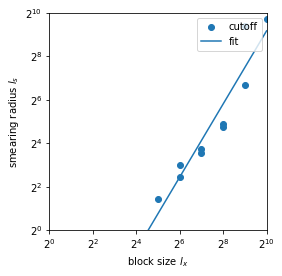

In [243]:
data_l=pd.DataFrame(data_l)
display(data_l)

# line fit data_l['lx'],data_l['lower_bound'] using numpy in loglog scale
# here we are not using custom fit. we are using numpy's polyfit
xfit,yfit=np.log2(data_l['lx']),np.log2(data_l['cutoff'])
#remove nans
xfit,yfit=xfit[~np.isnan(yfit)],yfit[~np.isnan(yfit)]
args=np.polyfit(xfit,yfit,1)
print('fitted params: ',args)
print('scaling',args[0])



plt.figure()
plt.scatter(data_l['lx'],data_l['cutoff'],label='cutoff')
x_test=np.geomspace(1,1024,100)
plt.plot(x_test,2**args[1]*x_test**args[0],label='fit')
plt.xscale(mpl.scale.LogScale('x',base=2));plt.xlim([1,1024])
plt.yscale(mpl.scale.LogScale('x',base=2));plt.ylim([1,1024])
plt.xlabel('block size $l_x$')
plt.ylabel('smearing radius $l_s$')
plt.legend(loc='upper right')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# no gilt 1.204545194045918
# gilt 1.6834794173385066